In [1]:
import time
import numpy as np
import pandas as pd
import hydroeval as he
import json
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, './CFE')
import bmi_cfe_open
import bmi_cfe_enkf_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI


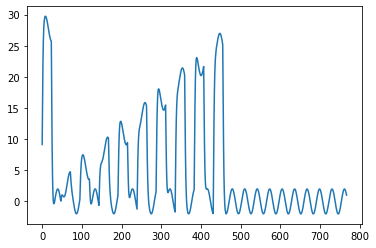

In [2]:
# GET OBSERVATIONS
cfe_obs = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_obs.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
with open(cfe_obs.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
OBSERVATIONS_LIST = []
for i, precip in enumerate(df_forcing['APCP_surface']): #i is RAINRATE
    cfe_obs.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) 
    cfe_obs.update()
    OBSERVATIONS_LIST.append(cfe_obs.get_value('land_surface_water__runoff_depth') + np.sin(i/5) * 2)
cfe_obs.finalize()
plt.plot(OBSERVATIONS_LIST)

In [3]:
## Open BMI's for each file
#cfe_open = bmi_cfe_open.BMI_CFE()
cfe_open = bmi_cfe_enkf_peturb.BMI_CFE() #One BMI to rule them all
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()

In [4]:
print(bmi_cfe_open)
print(bmi_cfe_enkf_peturb)
print(Bmi_da_ENKF_forSBMI)

<module 'bmi_cfe_open' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_open.py'>
<module 'bmi_cfe_enkf_peturb' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_enkf_peturb.py'>
<module 'Bmi_da_ENKF_forSBMI' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./Assimilation\\Bmi_da_ENKF_forSBMI.py'>


In [5]:

# ## Case study files
cfe_open.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
cfe_analysis.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
enkf.initialize(cfg_file='./Assimilation/EnKF_config-synthetic.json') # Need to create this still

initialized 10


              time  APCP_surface      T2D       Q2D     U2D     V2D  \
0     5/15/17 0:00            10  284.078  0.006616  6.0804 -1.9670   
1     5/15/17 1:00            10  283.180  0.006650  6.0304 -2.0740   
2     5/15/17 2:00            10  282.440  0.006614  5.9856 -2.1828   
3     5/15/17 3:00            10  281.662  0.006476  5.9402 -2.2888   
4     5/15/17 4:00            10  281.702  0.006530  6.3688 -2.5458   
..             ...           ...      ...       ...     ...     ...   
763  6/15/17 19:00             0  295.270  0.007334 -1.1600  4.5018   
764  6/15/17 20:00             0  294.610  0.006788 -1.2230  4.4990   
765  6/15/17 21:00             0  293.624  0.006776 -1.2812  4.4996   
766  6/15/17 22:00             0  292.722  0.006714 -1.5682  3.8524   
767  6/15/17 23:00             0  291.554  0.006650 -1.8486  3.1996   

          PSFC   SWDOWN   LWDOWN  
0     98376.98    0.000  318.822  
1     98378.60    0.000  317.996  
2     98380.28    0.000  317.736  
3     9

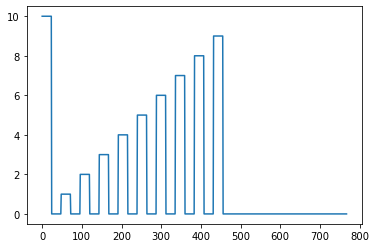

In [6]:
with open(cfe_open.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)
plt.plot(df_forcing['APCP_surface'])

values = df_forcing['APCP_surface']
print(values)

In [7]:
#Make empty matrices for plotting
cfeOpen = []
cfePeturbed = []
cfeAnalysis = []
cfeEnKF = []

## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['APCP_surface']): #i is RAINRATE

    # Set values for each model
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    
    obs = OBSERVATIONS_LIST[i]
    enkf.set_value('validity', 1)
    
    # Update CFE open and peturbed. Get value for peturbed stats. 
    cfe_open.update()
    cfe_peturbed.update()
    
    # Get state vars from Peturbed. These are values as enkf uses
    soil_storage_avail = cfe_peturbed.get_value('soil_storage_avail_m')
    soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_out_m')
    surface_runoff = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')
   
    # Get values for plotting
    outflow = cfe_open.get_value('land_surface_water__runoff_depth')
    cfeOpen.append(outflow) #for plotting
    outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    
    # Get mean and covariance for stats of ensemble runs for EnKF
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    cfePeturbed.append(outflow_peturb_mean) # For plotting
    
    # Set EnKF value to usgs, mean, and covariance. Get value from it then update
    enkf.set_value('soil_storage_avail_m', soil_storage_avail) #setting soil storage in enkf
    enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) #setting soil storage in enkf
    enkf.set_value('surface_runoff_depth_m', surface_runoff) #setting soil storage in enkf
    
    enkf.set_value('x', np.array([outflow_peturb_mean]))
    enkf.set_value('P', np.array([outflow_peturb_covar]))
    enkf.set_value('z', np.array([obs]))
    enkf.update()
    
    # For plotting
    outflow_enkf = enkf.get_value('enkf')
    cfeEnKF.append(outflow_enkf)
    
    # Get new EnKF state vars to give back to CFE Analysis
    state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
    state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_updated_m')
    state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')
    
    # Set value for CFE analysis based on the state variable change from the EnKF factor to get true streamflow
    cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage)    
    cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res)  
    cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)
    cfe_analysis.update() #get new streamflow value based on state var change
    
    # For plotting
    outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
    cfeAnalysis.append(outflow_analysis) 
        
    # Get values from new CFE analysis to put back into CFE Peturbed to keep look and EnKF going
    cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
    cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
    cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')
    
    # Set value from CFE analysis state variables back into CFE Peturbed to continue EnKF loop
    cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
    cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
    cfe_peturbed.set_value('state_var_change_runoff', cfe_updated_everything_runoff)
    
# # Finalize models
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
enkf.finalize()

Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.3121136221931379
EnKF Code predicted, X Post [2.56076334]
surface_runoff_ratio [0.71957861]
***********over estimaiton ratio [1.]
Observation BMI [9.14803171]
new value [0.71957861]
CFE [10.45598416]
enkf [2.56076334]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.29574402771625197
EnKF Code predicted, X Post [9.78222042]
surface_runoff_ratio [1.28648921]
***********over estimaiton ratio [1.]
Observation BMI [16.75252741]
new value [1.28648921]
CFE [12.98395883]
enkf [9.78222042]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.28078702857362736
EnKF Code predicted, X Post [5.79181763]
surface_runoff_ratio [1.70085208]
***********over estimaiton ratio [1.]
Observation BMI [22.40183725]
new value [1.70085208]
CFE [19.39808009]
enkf [5.79181763]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.2671209606679281
EnKF Code

EnKF Code predicted, X Post [0.76005912]
surface_runoff_ratio [0.21581761]
***********over estimaiton ratio [1.]
Observation BMI [0.78534248]
new value [0.21581761]
CFE [3.1850792]
enkf [0.76005912]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.20733921670138822
EnKF Code predicted, X Post [0.11156962]
surface_runoff_ratio [0.21596622]
***********over estimaiton ratio [1.]
Observation BMI [0.90693017]
new value [0.21596622]
CFE [2.67770678]
enkf [0.11156962]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.20020712986528277
EnKF Code predicted, X Post [0.21452272]
surface_runoff_ratio [0.21610353]
***********over estimaiton ratio [1.]
Observation BMI [1.10167565]
new value [0.21610353]
CFE [2.97419932]
enkf [0.21452272]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.19367836469922195
EnKF Code predicted, X Post [0.99195926]
surface_runoff_ratio [0.21623046]
***********over estimaiton ratio [1

EnKF Code predicted, X Post [1.81100289]
surface_runoff_ratio [0.43604663]
***********over estimaiton ratio [1.]
Observation BMI [3.59988142]
new value [0.43604663]
CFE [6.21457482]
enkf [1.81100289]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.1447414827080601
EnKF Code predicted, X Post [0.15357575]
surface_runoff_ratio [0.29262261]
***********over estimaiton ratio [1.]
Observation BMI [1.90896616]
new value [0.29262261]
CFE [4.0211991]
enkf [0.15357575]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.1529989038835663
EnKF Code predicted, X Post [0.17964833]
surface_runoff_ratio [0.1796181]
***********over estimaiton ratio [1.]
Observation BMI [0.67698065]
new value [0.1796181]
CFE [2.295182]
enkf [0.17964833]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.161122104850272
EnKF Code predicted, X Post [0.22443659]
surface_runoff_ratio [0.09703621]
***********over estimaiton ratio [1.]
Obser

***********over estimaiton ratio [1.]
Observation BMI [-1.87351525]
new value [0.00154632]
CFE [0.02079979]
enkf [-0.77239777]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.2351539805210493
EnKF Code predicted, X Post [-0.94305422]
surface_runoff_ratio [0.00154792]
***********over estimaiton ratio [1.]
Observation BMI [-1.96387897]
new value [0.00154792]
CFE [0.01882342]
enkf [-0.94305422]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.24194179222930212
EnKF Code predicted, X Post [-1.37592134]
surface_runoff_ratio [0.00154931]
***********over estimaiton ratio [1.]
Observation BMI [-1.97516715]
new value [0.00154931]
CFE [0.01561634]
enkf [-1.37592134]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.24861927148806306
EnKF Code predicted, X Post [-0.90560992]
surface_runoff_ratio [0.00155048]
***********over estimaiton ratio [1.]
Observation BMI [-1.90692918]
new value [0.00155048]
CFE [0.020

Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.2863447274687406
EnKF Code predicted, X Post [-0.21592333]
surface_runoff_ratio [0.00157673]
***********over estimaiton ratio [1.]
Observation BMI [-0.13202845]
new value [0.00157673]
CFE [0.02281224]
enkf [-0.21592333]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.2923004594516252
EnKF Code predicted, X Post [-0.04020648]
surface_runoff_ratio [0.00157562]
***********over estimaiton ratio [1.]
Observation BMI [-0.5251996]
new value [0.00157562]
CFE [0.02411523]
enkf [-0.04020648]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.2981593840205107
EnKF Code predicted, X Post [0.04789931]
***********under estimaiton ratio [2.25325243]
Observation BMI [-0.8966372]
under estimaiton [0.00354722]
CFE [0.02125785]
enkf [0.04789931]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.30392307473099567
EnKF Code predicted, X Post 

Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.21345526195074904
EnKF Code predicted, X Post [5.75457974]
surface_runoff_ratio [1.02493122]
***********over estimaiton ratio [1.]
Observation BMI [17.58320897]
new value [1.02493122]
CFE [17.76117249]
enkf [5.75457974]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.20561855400299944
EnKF Code predicted, X Post [8.06662308]
surface_runoff_ratio [1.16315503]
***********over estimaiton ratio [1.]
Observation BMI [17.21567929]
new value [1.16315503]
CFE [14.74470286]
enkf [8.06662308]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.19845775111512343
EnKF Code predicted, X Post [10.08941984]
surface_runoff_ratio [1.23976141]
***********over estimaiton ratio [1.]
Observation BMI [16.82517796]
new value [1.23976141]
CFE [13.94239596]
enkf [10.08941984]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.19191464679828052
EnKF

EnKF Code predicted, X Post [7.0721159]
surface_runoff_ratio [1.22129162]
***********over estimaiton ratio [0.80586399]
Observation BMI [21.33446957]
new value [1.22129162]
CFE [24.03734774]
enkf [7.0721159]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.15333470905913626
EnKF Code predicted, X Post [3.81367138]
surface_runoff_ratio [1.14575953]
***********over estimaiton ratio [0.80528017]
Observation BMI [21.17444522]
new value [1.14575953]
CFE [19.72472053]
enkf [3.81367138]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.1506831254156099
EnKF Code predicted, X Post [7.36825589]
surface_runoff_ratio [1.35037955]
***********over estimaiton ratio [1.]
Observation BMI [20.94494128]
new value [1.35037955]
CFE [14.85727543]
enkf [7.36825589]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.1482605873140136
EnKF Code predicted, X Post [8.69298356]
surface_runoff_ratio [1.39402559]
***********over 

Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.20650468483009055
EnKF Code predicted, X Post [1.21805897]
***********under estimaiton ratio [65.59693368]
Observation BMI [2.0174521]
under estimaiton [0.10410893]
CFE [0.01856884]
enkf [1.21805897]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.21375817636354477
EnKF Code predicted, X Post [1.75740196]
***********under estimaiton ratio [108.08384187]
Observation BMI [1.99838636]
under estimaiton [0.17165066]
CFE [0.01625962]
enkf [1.75740196]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.22089376605725275
EnKF Code predicted, X Post [1.32628826]
***********under estimaiton ratio [62.20867037]
Observation BMI [1.90045428]
under estimaiton [0.09884961]
CFE [0.02131999]
enkf [1.32628826]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.22791337034604464
EnKF Code predicted, X Post [1.3605083]
***********under estima

EnKF Code predicted, X Post [0.51716641]
***********under estimaiton ratio [27.51007964]
Observation BMI [0.77913187]
under estimaiton [0.04309759]
CFE [0.01879916]
enkf [0.51716641]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.3415664353864354
EnKF Code predicted, X Post [-0.6080436]
surface_runoff_ratio [0.00156309]
***********over estimaiton ratio [1.]
Observation BMI [0.39635651]
new value [0.00156309]
CFE [0.01700927]
enkf [-0.6080436]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.3466245664101959
EnKF Code predicted, X Post [-0.11885039]
surface_runoff_ratio [0.00155934]
***********over estimaiton ratio [1.]
Observation BMI [-0.0014311]
new value [0.00155934]
CFE [0.02184719]
enkf [-0.11885039]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.35160048006999745
EnKF Code predicted, X Post [-0.09399266]
surface_runoff_ratio [0.00155536]
***********over estimaiton ratio [1.]
Observation 

EnKF Code predicted, X Post [-0.71358286]
surface_runoff_ratio [0.00098421]
***********over estimaiton ratio [1.]
Observation BMI [-1.48244338]
new value [0.00098421]
CFE [0.01417027]
enkf [-0.71358286]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.5523052432834421
EnKF Code predicted, X Post [-0.42474862]
surface_runoff_ratio [0.00097412]
***********over estimaiton ratio [1.]
Observation BMI [-1.71671886]
new value [0.00097412]
CFE [0.01570524]
enkf [-0.42474862]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.5539379214694355
EnKF Code predicted, X Post [-0.58244326]
surface_runoff_ratio [0.00096406]
***********over estimaiton ratio [1.]
Observation BMI [-1.88206006]
new value [0.00096406]
CFE [0.01320006]
enkf [-0.58244326]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.5555440612964946
EnKF Code predicted, X Post [-1.37815317]
surface_runoff_ratio [0.00095404]
***********over estimaiton 

EnKF Code predicted, X Post [-0.91742042]
surface_runoff_ratio [0.0004533]
***********over estimaiton ratio [1.]
Observation BMI [-1.75615651]
new value [0.0004533]
CFE [0.00563122]
enkf [-0.91742042]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.6175595948125183
EnKF Code predicted, X Post [-0.90864038]
surface_runoff_ratio [0.00044721]
***********over estimaiton ratio [1.]
Observation BMI [-1.90913015]
new value [0.00044721]
CFE [0.00557777]
enkf [-0.90864038]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.6181315964868976
EnKF Code predicted, X Post [-1.25459893]
surface_runoff_ratio [0.00044118]
***********over estimaiton ratio [1.]
Observation BMI [-1.98576528]
new value [0.00044118]
CFE [0.0055441]
enkf [-1.25459893]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.6186943005630876
EnKF Code predicted, X Post [-0.9770885]
surface_runoff_ratio [0.00043521]
***********over estimaiton rati

EnKF Code predicted, X Post [0.17499337]
***********under estimaiton ratio [73.22312991]
Observation BMI [0.34018943]
under estimaiton [0.01138133]
CFE [0.00238986]
enkf [0.17499337]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.6422847494696728
EnKF Code predicted, X Post [0.61279554]
***********under estimaiton ratio [287.95791493]
Observation BMI [0.72503401]
under estimaiton [0.04408425]
CFE [0.00212807]
enkf [0.61279554]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.6424548562485188
EnKF Code predicted, X Post [0.75252942]
***********under estimaiton ratio [334.00993758]
Observation BMI [1.08105178]
under estimaiton [0.05036367]
CFE [0.00225302]
enkf [0.75252942]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.6426221980276283
EnKF Code predicted, X Post [0.40507167]
***********under estimaiton ratio [212.08165269]
Observation BMI [1.39404828]
under estimaiton [0.03149624]
CFE [0.00190

Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.6470429322848106
EnKF Code predicted, X Post [0.98220097]
***********under estimaiton ratio [748.67862723]
Observation BMI [1.994039]
under estimaiton [0.06481822]
CFE [0.00131191]
enkf [0.98220097]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.6471356972062674
EnKF Code predicted, X Post [0.21939913]
***********under estimaiton ratio [219.68950052]
Observation BMI [1.98765621]
under estimaiton [0.01872552]
CFE [0.00099868]
enkf [0.21939913]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.6472269542807993
EnKF Code predicted, X Post [0.72377554]
***********under estimaiton ratio [854.72619473]
Observation BMI [1.90207529]
under estimaiton [0.07172503]
CFE [0.00084679]
enkf [0.72377554]
Beginning----------------------------
self.f 0
soil_storage_deficit_from CFE 0.6473167280176961
EnKF Code predicted, X Post [0.84068605]
***********under estimait

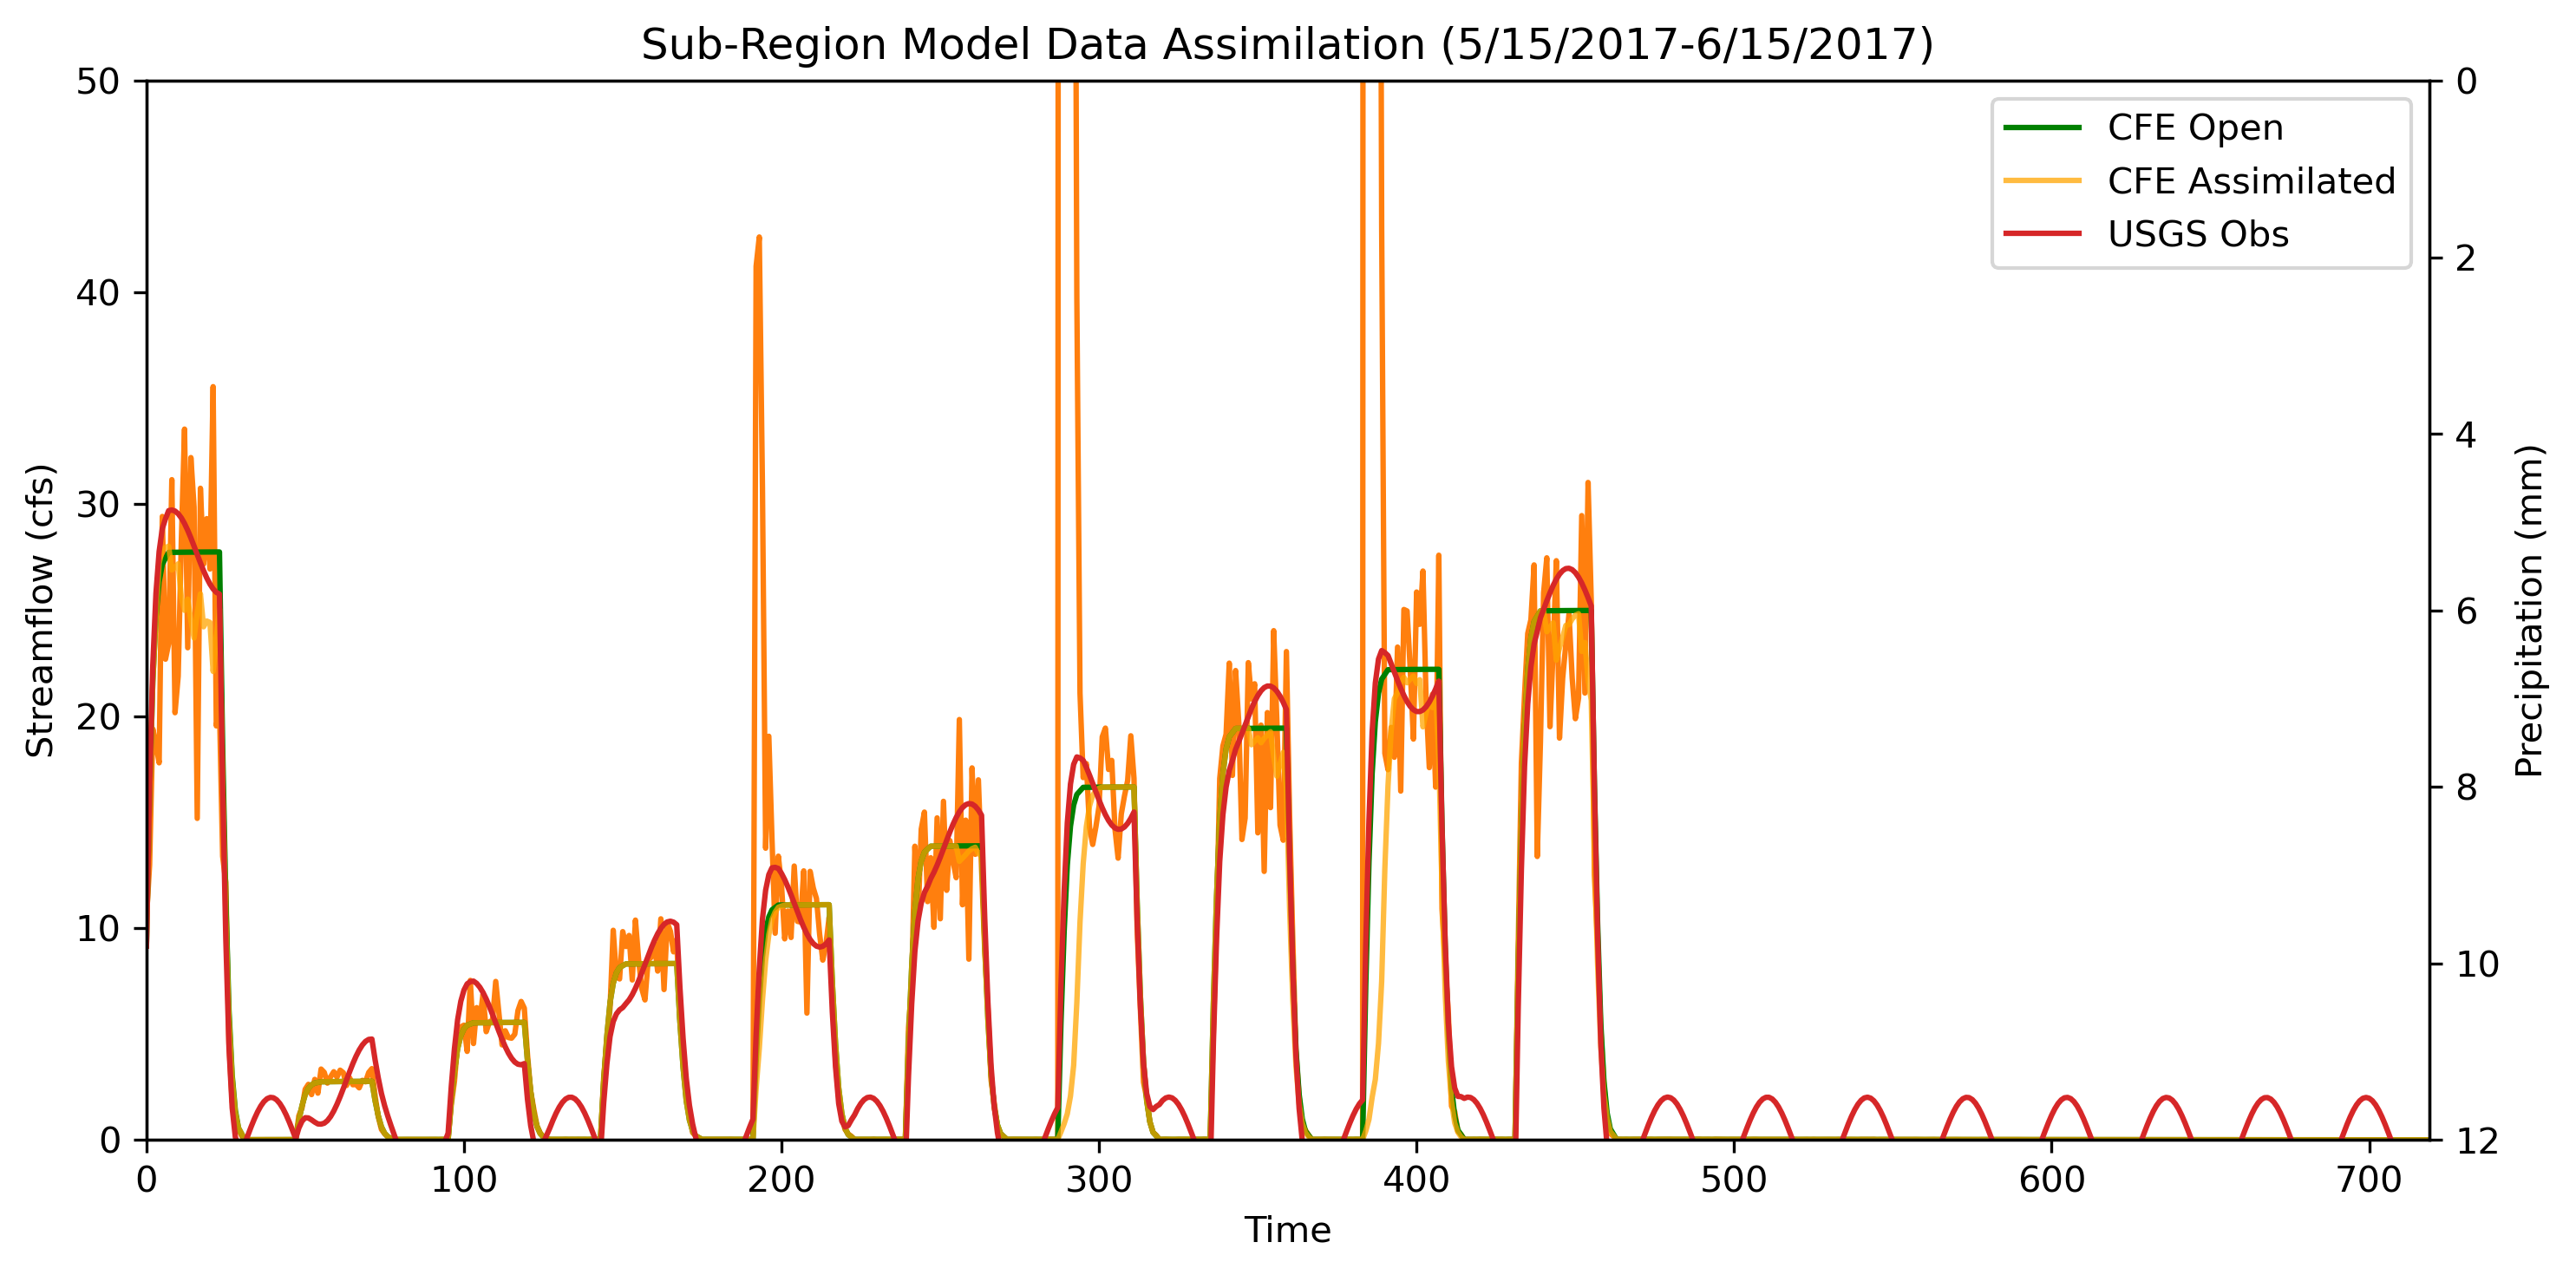

In [13]:
istart_plot=0
iend_plot=720
x = list(range(istart_plot, iend_plot))

fig, ax1 = plt.subplots(figsize = (10,5), dpi=300)

ax2 = ax1.twinx()

ax1.set_xlabel('Time')
ax1.set_ylabel('Streamflow (cfs)')
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(0,12,1)
ax2.invert_yaxis()
ax1.set_ylim(0,50,1)

plt.title('Sub-Region Model Data Assimilation (5/15/2017-6/15/2017)')
#Precip = ax2.bar(x, df_forcing['APCP_surface'][istart_plot:iend_plot],width=1,alpha=0.7, color="tab:blue", label = 'Precip')
ax1.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
Open, = ax1.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', label = 'CFE Open')
Analysis, = ax1.plot(x, cfeAnalysis[istart_plot:iend_plot], color = 'orange', alpha=0.75, label = 'CFE Assimilated')
Obs, = ax1.plot(x, OBSERVATIONS_LIST[istart_plot:iend_plot], color = 'tab:red', label = 'USGS Obs')
#ax1.plot(x, cfeEnKF[istart_plot:iend_plot], color = 'tab:blue', label = 'EnKF')

plt.legend(handles = [Open,Analysis,Obs], loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))

#plt.savefig("WorkingDA_7-19.png")
fig.tight_layout()
ax1.margins(x=0)

plt.show()


In [9]:
df=pd.DataFrame({"obs":OBSERVATIONS_LIST,"cfeAnalysis":cfeAnalysis,"cfeOpen":cfeOpen})
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,obs,cfeAnalysis,cfeOpen
0,9.148032,9.148032,9.148032
1,16.752527,16.355189,16.355189
2,22.401837,21.623001,21.623001
3,25.803301,24.674016,24.674016
4,27.774125,27.217177,26.339413
...,...,...,...
763,1.946724,0.000655,0.000655
764,1.816271,0.000645,0.000645
765,1.613436,0.000634,0.000634
766,1.346303,0.000624,0.000624


In [10]:
# CFE open eval
nse_open=he.evaluator(he.nse,df["obs"],df["cfeOpen"])
pbias=he.evaluator(he.pbias,df["obs"],df["cfeOpen"])
kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, df["obs"],df["cfeOpen"])
print("r_open=",r_open[0])
print("KGE_open=",kge_open[0])
print("NSE_open=", nse_open[0])
print("PBias=", pbias[0])

# CFE Analysis
nse_analysis=he.evaluator(he.nse,df["obs"],df["cfeAnalysis"])
pbias_analysis=he.evaluator(he.pbias,df["obs"],df["cfeAnalysis"])
kge_analysis, r_analysis, alpha_analysis, beta_analysis = he.evaluator(he.kge, df["obs"],df["cfeAnalysis"])
print("r_analysis=",r_analysis[0])
print("KGE_analysis=",kge_analysis[0])
print("NSE_analysis=", nse_analysis[0])
print("PBias=", pbias_analysis[0])

print("mean_obs=",np.mean(df["obs"]))
print("STD_obs=",np.std(df["obs"]))
print("mean_open=",np.mean(df["cfeOpen"]))
print("STD_open=",np.std(df["cfeOpen"]))
print("mean_analysis=",np.mean(df["cfeAnalysis"]))
print("STD_analysis=",np.std(df["cfeAnalysis"]))

r_open= 0.9847685621870116
KGE_open= 0.9738968324390085
NSE_open= 0.9684789130731811
PBias= -0.5190748263743952
r_analysis= 0.957250242973915
KGE_analysis= 0.8617777012890485
NSE_analysis= 0.8954748317217718
PBias= -9.54933720935838
mean_obs= 4.800312978052866
STD_obs= 8.136825159788623
mean_open= 4.775524432894345
STD_open= 7.972955267955365
mean_analysis= 4.381873136191634
STD_analysis= 7.4627417577817425
